In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import gymnasium as gym
import random
import seaborn as sns

# Setting up the environment

In [ ]:
env = gym.make('Pendulum-v1')
print("Environment created successfully!")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

Environment created successfully!
Observation space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Action space: Box(-2.0, 2.0, (1,), float32)


# Discretizing the observation space

Since the pundulum environment has a continuous space we need to discretize the environment in order to use the Monte Carlo method. This  happens because this method needs to track separate values for each state (which is impossible with the current set up).

In [ ]:
def setup_discretization():
    obs_bins = [
        np.linspace(-1, 1, 21),
        np.linspace(-1, 1, 21),
        np.linspace(-8, 8, 21),
    ]
    
    action_vals = np.linspace(-2, 2, 17)
    
    return obs_bins, action_vals

def discretize_observation(obs, obs_bins):
    return tuple(np.digitize(obs[i], obs_bins[i]) for i in range(len(obs)))

obs_bins, action_vals = setup_discretization()

print(f"Action space size: {len(action_vals)} discrete actions")
print(f"Action values: {action_vals}")

Action space size: 17 discrete actions
Action values: [-2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.  ]


# Monte Carlo

First as a baseline the group decided to use the monte carlo method.n this case the group choose first visit monte carlo due to its easier implementation.

In [ ]:
class MonteCarloAgent:
    def __init__(self, n_actions, gamma=0.99, alpha=0.1, epsilon=1.0, 
                 epsilon_decay=0.9995, epsilon_min=0.05):
        self.n_actions = n_actions
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        
        self.returns = []
        self.episode_lengths = []
        self.exploration_rates = []
        
    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        else:
            return np.argmax(self.Q[state])
    
    def update_q_values(self, trajectory):
        G = 0
        visited = set()
        
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            
            G = reward + self.gamma * G
            
            if (state, action) not in visited:
                self.Q[state][action] += self.alpha * (G - self.Q[state][action])
                visited.add((state, action))
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def record_episode_stats(self, episode_return, episode_length):
        self.returns.append(episode_return)
        self.episode_lengths.append(episode_length)
        self.exploration_rates.append(self.epsilon)

mc_agent = MonteCarloAgent(
    n_actions=len(action_vals),
    gamma=0.99,
    alpha=0.1,
    epsilon=1.0,
    epsilon_decay=0.9995,
    epsilon_min=0.05
)

print(f"Hyperparameters:\nDiscount factor (γ): {mc_agent.gamma}\nLearning rate (α): {mc_agent.alpha}\nInitial exploration (ε): {mc_agent.epsilon}\nEpsilon decay: {mc_agent.epsilon_decay}\nMinimum epsilon: {mc_agent.epsilon_min}")

Hyperparameters:
Discount factor (γ): 0.99
Learning rate (α): 0.1
Initial exploration (ε): 1.0
Epsilon decay: 0.9995
Minimum epsilon: 0.05


## Training

In [ ]:
num_episodes = 20000
window = 100

print(f"Training episodes: {num_episodes:,}")
print("-" * 50)

for episode in range(num_episodes):
    obs, _ = env.reset()
    state = discretize_observation(obs, obs_bins)
    
    trajectory = []
    done = False
    
    while not done:
        action_idx = mc_agent.select_action(state)
        
        action = np.array([action_vals[action_idx]])
        
        next_obs, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize_observation(next_obs, obs_bins)
        
        trajectory.append((state, action_idx, reward))
        
        state = next_state
        done = terminated or truncated
    
    mc_agent.update_q_values(trajectory)
    
    episode_return = sum(reward for _, _, reward in trajectory)
    episode_length = len(trajectory)
    
    mc_agent.record_episode_stats(episode_return, episode_length)
    mc_agent.decay_epsilon()
    
    if (episode + 1) % 1000 == 0:
        avg_return = np.mean(mc_agent.returns[-window:])
        print(f"Episode {episode + 1:5d} | "
              f"Avg Return: {avg_return:8.2f} | "
              f"Epsilon: {mc_agent.epsilon:.4f}")

print("\nTraining completed")
print(f"Total episodes: {len(mc_agent.returns)}")
print(f"Final epsilon: {mc_agent.epsilon:.4f}")
print(f"Q-table size: {len(mc_agent.Q)}")


Training episodes: 20,000
--------------------------------------------------
Episode  1000 | Avg Return: -1173.65 | Epsilon: 0.6065
Episode  2000 | Avg Return: -1019.96 | Epsilon: 0.3678
Episode  3000 | Avg Return:  -583.01 | Epsilon: 0.2230
Episode  4000 | Avg Return:  -453.68 | Epsilon: 0.1353
Episode  5000 | Avg Return:  -285.23 | Epsilon: 0.0820
Episode  6000 | Avg Return:  -284.78 | Epsilon: 0.0500
Episode  7000 | Avg Return:  -281.18 | Epsilon: 0.0500
Episode  8000 | Avg Return:  -289.16 | Epsilon: 0.0500
Episode  9000 | Avg Return:  -320.70 | Epsilon: 0.0500
Episode 10000 | Avg Return:  -294.81 | Epsilon: 0.0500
Episode 11000 | Avg Return:  -480.80 | Epsilon: 0.0500
Episode 12000 | Avg Return:  -315.12 | Epsilon: 0.0500
Episode 13000 | Avg Return:  -333.89 | Epsilon: 0.0500
Episode 14000 | Avg Return:  -294.39 | Epsilon: 0.0500
Episode 15000 | Avg Return:  -339.57 | Epsilon: 0.0500
Episode 16000 | Avg Return:  -350.15 | Epsilon: 0.0500
Episode 17000 | Avg Return:  -320.08 | Epsi

## Evaluation 

In [ ]:
def evaluate_agent(env, agent, obs_bins, action_vals, eval_episodes=1000):
    print(f"Evaluating agent over {eval_episodes} episodes")

    eval_returns = []
    success_threshold = -250

    for episode in range(eval_episodes):
        obs, _ = env.reset()
        state = discretize_observation(obs, obs_bins)
        done = False
        episode_return = 0

        while not done:
            action_idx = np.argmax(agent.Q[state])
            action = np.array([action_vals[action_idx]])
            obs, reward, terminated, truncated, _ = env.step(action)
            state = discretize_observation(obs, obs_bins)
            episode_return += reward
            done = terminated or truncated

        eval_returns.append(episode_return)

    metrics = {
        'mean_return': np.mean(eval_returns),
        'std_return': np.std(eval_returns),
        'success_rate': sum(1 for r in eval_returns if r > success_threshold) / eval_episodes,
        'best_return': max(eval_returns),
        'worst_return': min(eval_returns)
    }

    return metrics, eval_returns
metrics, eval_returns = evaluate_agent(env, mc_agent, obs_bins, action_vals, eval_episodes=1000)

print(f"\nEVALUATION RESULTS")
print(f"Mean Return: {metrics['mean_return']:.2f} ± {metrics['std_return']:.2f}")
print(f"Success Rate (>-250): {metrics['success_rate']:.1%}")
print(f"Best Return: {metrics['best_return']:.2f}")
print(f"Worst Return: {metrics['worst_return']:.2f}")

Evaluating agent over 1000 episodes

EVALUATION RESULTS
Mean Return: -277.13 ± 293.65
Success Rate (>-250): 65.2%
Best Return: -2.28
Worst Return: -1863.02


## Plotting the metrics

In [ ]:
def plot_learning_curve(agent, window=100, label=None):
    if hasattr(agent, 'returns'):
        rewards = agent.returns
        default_label = 'Monte Carlo (Smoothed)'
    elif hasattr(agent, 'episode_rewards'):
        rewards = agent.episode_rewards
        default_label = 'Q-Learning (Smoothed)'
    else:
        raise ValueError("Agent does not have 'returns' or 'episode_rewards' attribute.")
    
    if label is None:
        label = default_label

    plt.figure(figsize=(10, 6))
    if len(rewards) >= window:
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(smoothed, label=label)
    else:
        plt.plot(rewards, label=label)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Learning Curve')
    plt.grid()
    plt.legend()

    plt.show()

def plot_exploration_rate(agent, ax=None):
    if ax is None:
        ax = plt.gca()
    episodes = range(len(agent.exploration_rates))
    ax.plot(episodes, agent.exploration_rates, color='purple', linewidth=2)
    ax.set_xlabel('Episode')
    ax.set_ylabel('Epsilon (Exploration Rate)')
    ax.set_title('Exploration Rate Decay')
    ax.grid(True, alpha=0.3)

def plot_eval_distribution(agent, eval_returns=None, ax=None):
    if ax is None:
        ax = plt.gca()
    if eval_returns is not None:
        ax.hist(eval_returns, bins=50, alpha=0.7, color='orange', edgecolor='black')
        ax.axvline(np.mean(eval_returns), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(eval_returns):.2f}')
        ax.set_xlabel('Return')
        ax.set_ylabel('Frequency')
        ax.set_title('Evaluation Return Distribution')
        ax.legend()
    else:
        if len(agent.returns) >= 1000:
            recent_window = 1000
            recent_returns = agent.returns[-recent_window:]
            recent_episodes = range(len(agent.returns) - recent_window, len(agent.returns))
            ax.plot(recent_episodes, recent_returns, alpha=0.6, color='orange')
            z = np.polyfit(recent_episodes, recent_returns, 1)
            p = np.poly1d(z)
            ax.plot(recent_episodes, p(recent_episodes), color='red', linewidth=2, linestyle='--', label='Trend')
            ax.set_title(f'Recent Performance (Last {recent_window} Episodes)')
        ax.set_xlabel('Episode')
        ax.set_ylabel('Return')
        ax.legend()
    ax.grid(True, alpha=0.3)


<Figure size 1200x800 with 0 Axes>

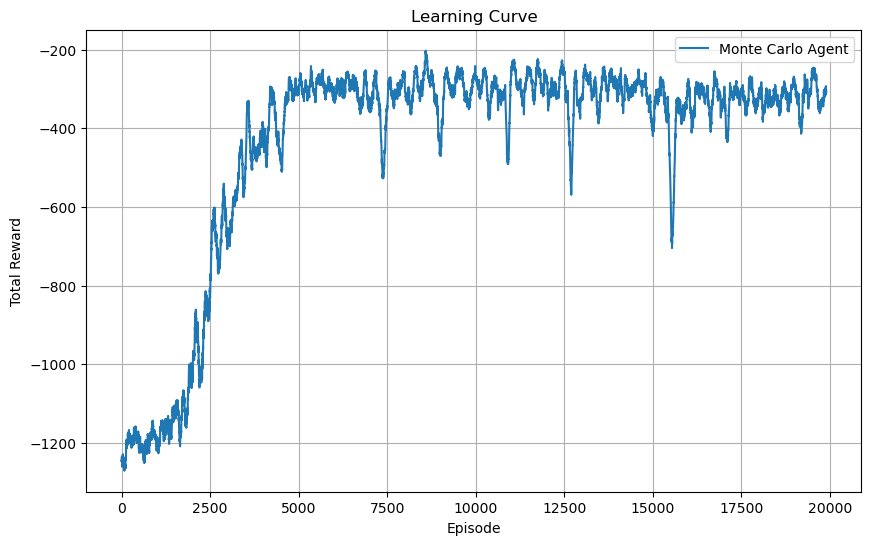

In [ ]:
plt.figure(figsize=(12, 8))
plot_learning_curve(mc_agent, window=100, label='Monte Carlo Agent')

The "learning curve" displays the learning process of the alorithm over it's 20000 episodes. From the plot it is possible to conclude that altough the learner starts with a bad total reward it quickly manages to diminish it standardizing to a -200 to -500 total reward range at around the 6000th episode. Still it is possible to see that the algortihm is still learning as some episodes feature rewards that are out of the sabilized range.

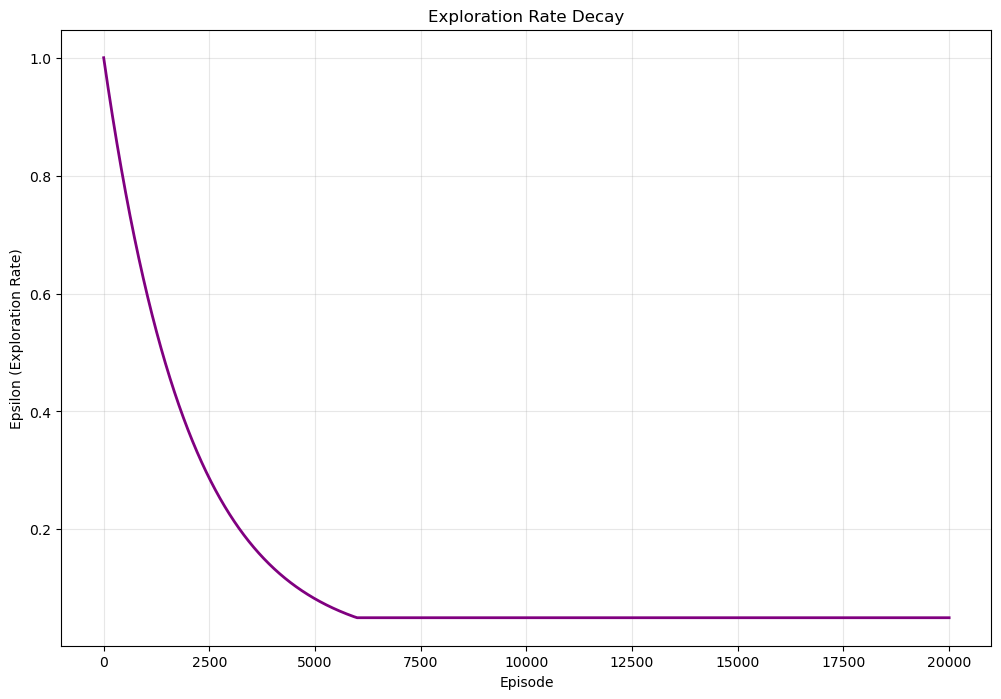

In [ ]:
plt.figure(figsize=(12, 8))
plot_exploration_rate(mc_agent)

The exploration rate decay gives an inidcation of how the algortihtm hanfles exploration and exploitation. From this plot it is possible to conclude that  the agent starts by exploring the envronment with total freedom but by the 50 episode it mostly exploits instead of exploring. By, around, the 6000th episode the algorithm only exploits with the exploration decay having had enough time to reach 0.

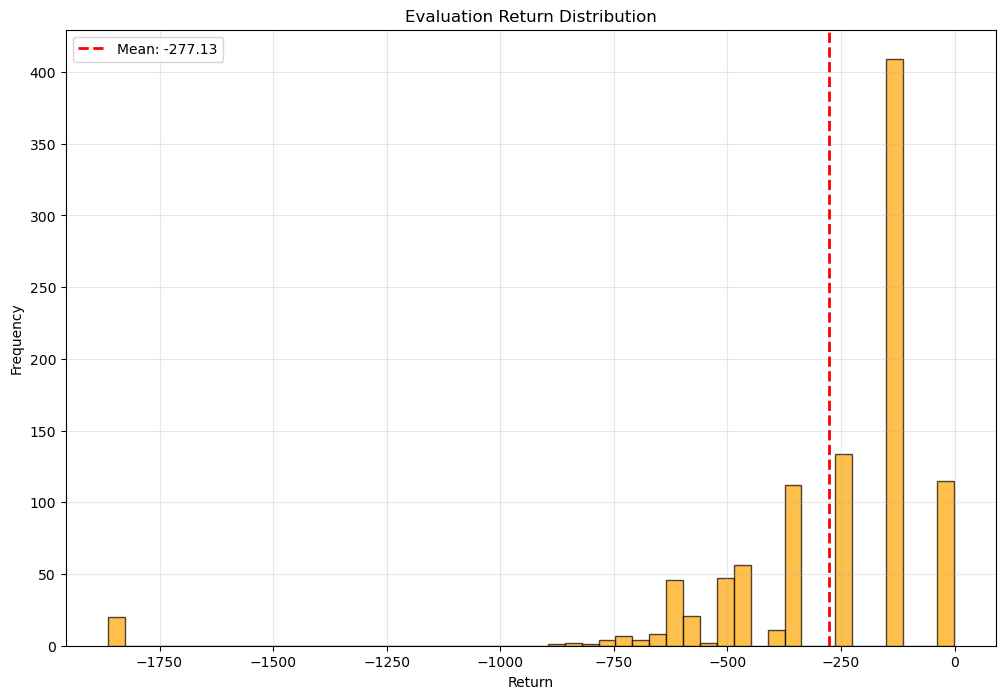

In [ ]:
plt.figure(figsize=(12, 8))
plot_eval_distribution(mc_agent, eval_returns)

The reward distribution plot functions as a visualization of the rewards in a histogram form with the average reward included. The plot draws an image that is remindful of the one viewed in the learning curve plot where the agebt starts of with a bad reward but quickly learns and tends to grow over time to a stabilized range of -500 to -200. It is also possible to see that the average return stands at -286.76 which is in the middle of the space where there are the most returns (in terms of frequency).

## Final Analysis

In [ ]:
print(f"LEARNING PROGRESS ANALYSIS")

early_episodes = mc_agent.returns[:1000]
late_episodes = mc_agent.returns[-1000:]

print(f"Early Performance (Episodes 1-1000):")
print(f"  Mean Return: {np.mean(early_episodes):.2f}")
print(f"  Std Return: {np.std(early_episodes):.2f}")

print(f"\nLate Performance (Last 1000 episodes):")
print(f"  Mean Return: {np.mean(late_episodes):.2f}")
print(f"  Std Return: {np.std(late_episodes):.2f}")

improvement = np.mean(late_episodes) - np.mean(early_episodes)
print(f"\nImprovement: {improvement:.2f} points")

if len(mc_agent.returns) >= 5000:
    recent_performance = mc_agent.returns[-1000:]
    convergence_threshold = 350
    
    if np.std(recent_performance) < convergence_threshold:
        print(f"\nThe agent appears to have converged (std < {convergence_threshold})")
    else:
        print(f"\nThe agent may still be learning (std = {np.std(recent_performance):.2f})")

print(f"\nQ-Table Statistics:")
print(f"  States visited: {len(mc_agent.Q)}")
print(f"  Total state-action pairs: {len(mc_agent.Q) * len(action_vals):,}")
print(f"  Coverage: {len(mc_agent.Q) / (21**3) * 100:.2f}% of possible states")

env.close()

LEARNING PROGRESS ANALYSIS
--------------------------------------------------
Early Performance (Episodes 1-1000):
  Mean Return: -1205.27
  Std Return: 288.17

Late Performance (Last 1000 episodes):
  Mean Return: -313.83
  Std Return: 303.62

Improvement: 891.44 points

The agent appears to have converged (std < 350)

Q-Table Statistics:
  States visited: 1267
  Total state-action pairs: 21,539
  Coverage: 13.68% of possible states


# Q-Learning

Q-Learning is a model-free algorithm in which the "[...] agent builds a Q-table which stores Q-values. Each Q-value estimates how good it is to take a specific action in a given state in terms of the expected future rewards. Over time the agent updates this table using the feedback it receives from the environment." (GeeksforGeeks, 2025)

In [ ]:
env = gym.make('Pendulum-v1')
obs_bins, action_vals = setup_discretization()

In [ ]:
class QLearningAgent:
    def __init__(self, n_actions, gamma=0.9, alpha=0.85, epsilon=1.0,
                 epsilon_decay=0.995, epsilon_min=0.05, max_steps=200):
        self.n_actions = n_actions
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.max_steps = max_steps
        
        self.Q = defaultdict(lambda: np.zeros(n_actions))
        self.episode_rewards = []
        self.exploration_rates = []
    
    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, self.n_actions - 1)
        else:
            return int(np.argmax(self.Q[state]))
    
    def update_q_value(self, state, action, reward, next_state, done):
        best_next_q = np.max(self.Q[next_state]) if not done else 0
        td_target = reward + self.gamma * best_next_q
        td_delta = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_delta
    
    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def record_episode_stats(self, episode_reward):
        self.episode_rewards.append(episode_reward)
        self.exploration_rates.append(self.epsilon)

q_agent = QLearningAgent(
    n_actions=len(action_vals),
    gamma=0.9,
    alpha=0.85,
    epsilon=1.0,
    epsilon_decay=0.995,
    epsilon_min=0.05,
    max_steps=200
)

print(f"Hyperparameters:\nDiscount factor (γ): {q_agent.gamma}\nLearning rate (α): {q_agent.alpha}\nInitial exploration (ε): {q_agent.epsilon}\nEpsilon decay: {q_agent.epsilon_decay}\nMinimum epsilon: {q_agent.epsilon_min}")

Hyperparameters:
Discount factor (γ): 0.9
Learning rate (α): 0.85
Initial exploration (ε): 1.0
Epsilon decay: 0.995
Minimum epsilon: 0.05


The agent trained for 15000 episodes and the progress was monitored through average rewards over 100 episode windows, showing the learning progression from random performance to optimized policy.

## Training

In [ ]:
num_episodes = 15000
window = 100

print(f"Training episodes: {num_episodes:,}")
print("-" * 50)

for episode in range(num_episodes):
    obs, _ = env.reset()
    state = discretize_observation(obs, obs_bins)
    total_reward = 0
    done = False

    for step in range(q_agent.max_steps):
        action_idx = q_agent.select_action(state)
        action = np.array([action_vals[action_idx]])

        next_obs, reward, terminated, truncated, _ = env.step(action)
        next_state = discretize_observation(next_obs, obs_bins)
        done = terminated or truncated

        q_agent.update_q_value(state, action_idx, reward, next_state, done)
        state = next_state
        total_reward += reward

        if done:
            break

    q_agent.record_episode_stats(total_reward)
    q_agent.decay_epsilon()

    if (episode + 1) % 1000 == 0:
        avg_return = np.mean(q_agent.episode_rewards[-window:])
        print(f"Episode {episode + 1:5d} | Avg Return: {avg_return:8.2f} | Epsilon: {q_agent.epsilon:.4f}")

print("\nTraining completed")
print(f"Total episodes: {len(q_agent.episode_rewards)}")
print(f"Final epsilon: {q_agent.epsilon:.4f}")
print(f"Q-table size: {len(q_agent.Q)}")

Training episodes: 15,000
--------------------------------------------------
Episode  1000 | Avg Return:  -956.72 | Epsilon: 0.0500
Episode  2000 | Avg Return:  -750.87 | Epsilon: 0.0500
Episode  3000 | Avg Return:  -575.23 | Epsilon: 0.0500
Episode  4000 | Avg Return:  -489.95 | Epsilon: 0.0500
Episode  5000 | Avg Return:  -417.18 | Epsilon: 0.0500
Episode  6000 | Avg Return:  -468.62 | Epsilon: 0.0500
Episode  7000 | Avg Return:  -548.68 | Epsilon: 0.0500
Episode  8000 | Avg Return:  -554.30 | Epsilon: 0.0500
Episode  9000 | Avg Return:  -513.25 | Epsilon: 0.0500
Episode 10000 | Avg Return:  -494.71 | Epsilon: 0.0500
Episode 11000 | Avg Return:  -448.89 | Epsilon: 0.0500
Episode 12000 | Avg Return:  -455.41 | Epsilon: 0.0500
Episode 13000 | Avg Return:  -416.07 | Epsilon: 0.0500
Episode 14000 | Avg Return:  -448.51 | Epsilon: 0.0500
Episode 15000 | Avg Return:  -427.62 | Epsilon: 0.0500

Training completed
Total episodes: 15000
Final epsilon: 0.0500
Q-table size: 1318


## Evaluation

To better visualize learning trends and reduce the noise inherent in episodic rewards, the group applied a moving average smoothing with a window size of 50.

In [ ]:
def smooth(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

metrics, eval_returns = evaluate_agent(env, q_agent, obs_bins, action_vals, eval_episodes=1000)
print(f"\nEVALUATION RESULTS")
print(f"Mean Return: {metrics['mean_return']:.2f} ± {metrics['std_return']:.2f}")
print(f"Success Rate (>-250): {metrics['success_rate']:.1%}")
print(f"Best Return: {metrics['best_return']:.2f}")
print(f"Worst Return: {metrics['worst_return']:.2f}")
smoothed_returns = smooth(q_agent.episode_rewards, window_size=100)

Evaluating agent over 1000 episodes

EVALUATION RESULTS
Mean Return: -350.70 ± 243.67
Success Rate (>-250): 41.3%
Best Return: -0.67
Worst Return: -1132.66


The first thing the group did was check the Total Reward per episode and there is a clear upward trend until the episode 4000, meaning that learning is happening.

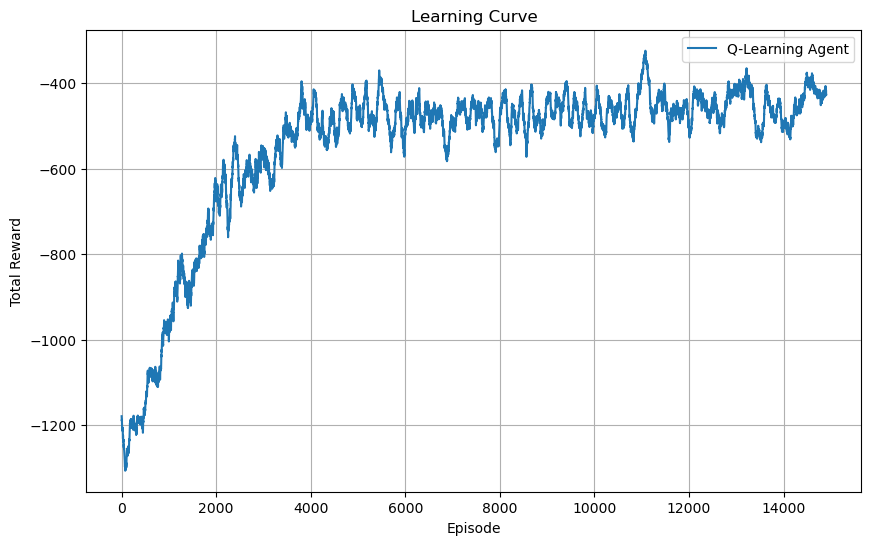

In [ ]:
plot_learning_curve(q_agent, window=100, label='Q-Learning Agent')

To analyze and visualize the convergence speed, that tells how fast the agent improves, the group measured the episode number when the smoothed reward first exceeds a threshold (-350) for at least 10 consecutive episodes.

In [ ]:
def find_convergence_episode(rewards, threshold=-350, patience=10):
    for i in range(len(rewards) - patience):
        if all(r > threshold for r in rewards[i:i+patience]):
            return i
    return None

In [ ]:
smoothed_rewards = smooth(q_agent.episode_rewards)

In [ ]:
convergence_episode = find_convergence_episode(smoothed_rewards)
print(f"Convergence detected at episode: {convergence_episode}")

Convergence detected at episode: 11048


In Q-learning, the Exploration/Exploration trade-off is controlled by the epsilon value in the epsilon-greedy policy, where:
- High epsilon → more exploration (random actions).
- Low epsilon → more exploitation (greedy actions from Q-table).

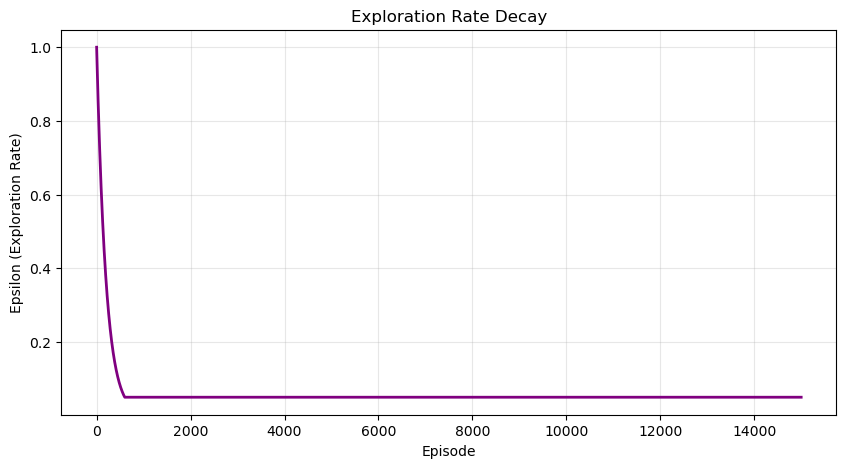

In [ ]:
plt.figure(figsize=(10, 5))
plot_exploration_rate(q_agent)

At the beginning of training, epsilon = 1.0, leading the agent to explore actions randomly. Over time, epsilon decayed exponentially to 0.01, allowing the agent to increasingly exploit the best known actions.
This balance allowed the agent to explore the action space early in training, and then stabilize performance through exploitation.

Next, the group performed an histogram with the distribution of the agent's performance during an evaluation phase.

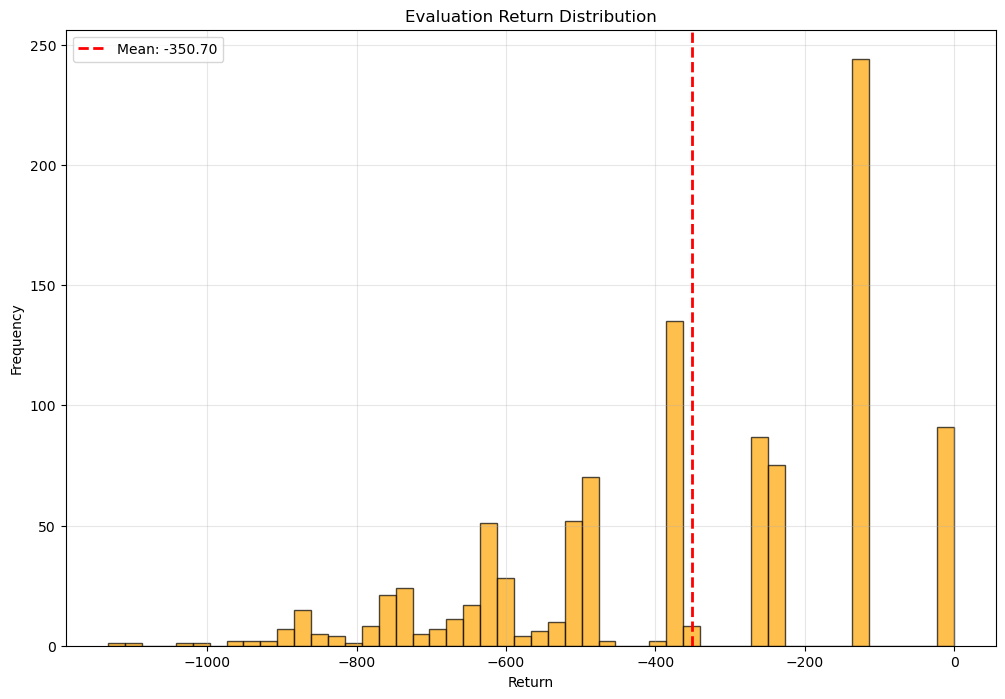

In [ ]:
plt.figure(figsize=(12, 8))
plot_eval_distribution(q_agent, eval_returns)

The mean return of -453.30 gives summary of the agent's average performance, while the distribution itself reveals the consistency and variability of that performance. The distribution shows a right-skewed pattern with a peak around -350 to -300, indicating the agent learned a consistent control strategy. A good portion of episodes exceed the -300 success threshol, however, the presence of a long tail extending to very poor performance below -1000 reveals occasional episodes where the agent fails. Overall, the agent successfully learned a working pendulum control policy.

Next, the group visualized the learning progress through the success rate over time, accounting only for episodes with reward > -300 (smoothed over a 50-episode window).

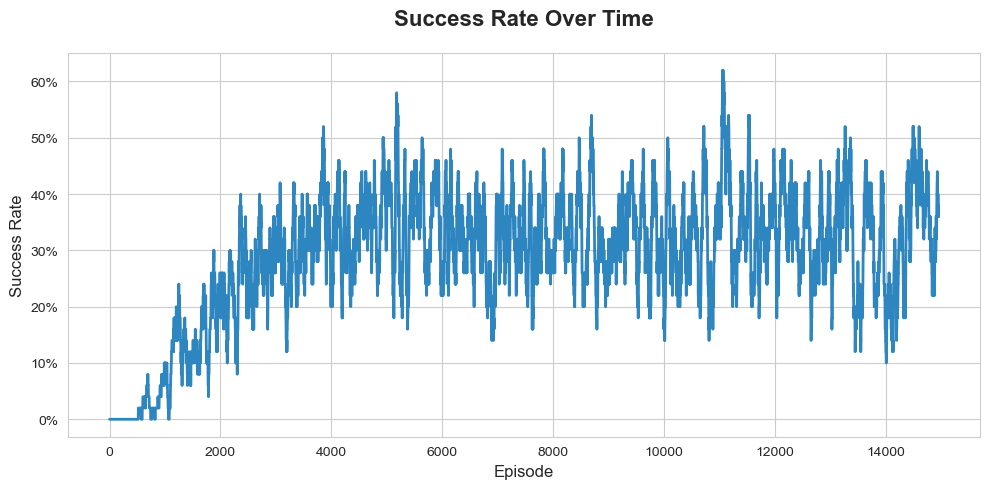

In [ ]:
success_threshold = -300
success_rate = [1 if r > success_threshold else 0 for r in q_agent.episode_rewards]
smoothed_success_rate = np.convolve(success_rate, np.ones(50)/50, mode='valid')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)


plt.figure(figsize=(10, 5))
plt.plot(smoothed_success_rate, linewidth=2, color='#2E86C1')

plt.title('Success Rate Over Time', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Episode', fontsize=12)
plt.ylabel('Success Rate', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

plt.tight_layout()
plt.show()

It's possible to see that the learning begins around episode 1500 with steady improvement through episode 4000, where success rates climb from 0% to 30-40%. From episode 4000, the agent maintains a performance plateau with sucess rates between 15 and 60%. The high variability throughout the later episodes suggests the tabular Q-learning approach has reached its performance limit for this continuous control problem. This happens likely because the agent must discretize the states and actions to work with a Q-table that leads to a loss of important information about the differences between similar states.

# Part 2 - LunarLander Continuous Control with RL

In this part, we train and evaluate reinforcement learning agents (DDPG and PPO) on the `LunarLander-v3` environment with continuous actions. We use `Stable-Baselines3` and explore how our agents perform over time under wind and turbulence.

In [1]:
import os
import random
import numpy as np
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim.lr_scheduler as lr_scheduler
from torch.autograd import Variable
from collections import deque, namedtuple

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#! pip install swig
#! pip install gymnasium
#! pip install gymnasium[box2d]

In [3]:
env = gym.make("LunarLander-v3", gravity=-10, continuous=False,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode="human")

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)



Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)


c:\IMS\RL\.rl_venv\Lib\site-packages\pygame\pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [4]:
state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]
number_actions = env.action_space.n

In [5]:
print('State shape: ', state_shape)
print('State size: ', state_size)
print('Number of actions: ', number_actions)

State shape:  (8,)
State size:  8
Number of actions:  4


## Testing the environment  with a random policy

In [6]:

def random_policy(env, state):
    return env.action_space.sample()

state = env.reset()[0]

for counter in range(201):

    env.render()

    #select the action according to the given policy
    action = random_policy(env, state)
    
    #perform the action and store the next state information
    next_state, reward, done, truncated, info = env.step(action)

    if counter % 10 == 0:
        print("Step:", counter, next_state, reward, done, info)
        
env.close()

Step: 0 [-0.00612135  1.4212496  -0.30958977  0.21669027  0.00702316  0.06940726
  0.          0.        ] 0.7273891050646739 False {}
Step: 10 [-0.03497028  1.4575154  -0.27022138  0.15673104  0.07020166  0.10953134
  0.          0.        ] -1.714970942455227 False {}
Step: 20 [-0.06109371  1.4738648  -0.28241506  0.06195458  0.08890585  0.05579451
  0.          0.        ] -2.130328354768113 False {}
Step: 30 [-0.0884882   1.4679875  -0.29529357 -0.0338395   0.11547753  0.02994144
  0.          0.        ] 0.40354799723654083 False {}
Step: 40 [-0.11831598  1.4321207  -0.2847009  -0.26485905  0.14241597 -0.01077799
  0.          0.        ] -1.1401543345595542 False {}
Step: 50 [-0.14752197  1.360403   -0.30378807 -0.42331487  0.13546245  0.03660605
  0.          0.        ] -1.4107866745703461 False {}
Step: 60 [-0.18339415  1.256942   -0.36048463 -0.5427233   0.16307253 -0.0077882
  0.          0.        ] -0.3067312225670935 False {}
Step: 70 [-0.21970582  1.1060138  -0.39808017 

In [7]:
seed_value = 42

env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
env.reset(seed=seed_value)



state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_low = float(env.action_space.low[0])
action_high = float(env.action_space.high[0])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
env.close()

## stable-baselines DDPG

We initialize a Deep Deterministic Policy Gradient (DDPG) agent with action noise to encourage exploration. The policy uses a two-layer neural network.

In [9]:
import gymnasium as gym
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
import numpy as np
import torch


seed_value = 42

env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5)
env.reset(seed=seed_value)

# Get dimensions
n_actions = env.action_space.shape[0]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.2 * np.ones(n_actions))

policy_kwargs = dict(net_arch=[256, 256])


# Define model
model = DDPG(
    "MlpPolicy",
    env,
    action_noise=action_noise,
    policy_kwargs=policy_kwargs,
    verbose=0,
    learning_rate=1e-3,
    buffer_size=1_000_000,
    batch_size=128,
    gamma=0.99,
    tau=0.005,
    train_freq=(1, "step"),
    gradient_steps=1,
    device="auto",  # "cuda" or "cpu"
    seed=seed_value
)

# Track episode rewards
episode_rewards = []
n_eval_episodes = 10
eval_interval = 5000  # evaluate every 5k steps
total_timesteps = 1_000_000
timesteps = 0
eval_results = []

# Helper function for evaluation
def evaluate(model, env, n_episodes=10):
    rewards = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        rewards.append(total_reward)
    return np.mean(rewards), rewards

# Train in intervals, evaluate and log
while timesteps < total_timesteps:
    model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)
    timesteps += eval_interval
    mean_reward, rewards = evaluate(model, env, n_episodes=n_eval_episodes)
    episode_rewards.append(mean_reward)

    # Compute success rate: consider reward > 200 as a successful landing
    success_count = sum(r > 200 for r in rewards)
    success_rate = success_count / len(rewards)

    # Store all metrics
    eval_results.append({
        "timesteps": timesteps,
        "mean_reward": mean_reward,
        "success_rate": success_rate
    })

    print(f"Evaluation at step {timesteps}: Mean Reward = {mean_reward:.2f}, Success Rate = {success_rate:.2f}")


# Save model and close environment
model.save("ddpg_lunar")
env.close()



Evaluation at step 5000: Mean Reward = -173.11, Success Rate = 0.00
Evaluation at step 10000: Mean Reward = -158.49, Success Rate = 0.00
Evaluation at step 15000: Mean Reward = -112.78, Success Rate = 0.00
Evaluation at step 20000: Mean Reward = -85.96, Success Rate = 0.00
Evaluation at step 25000: Mean Reward = -209.05, Success Rate = 0.00
Evaluation at step 30000: Mean Reward = -292.96, Success Rate = 0.00
Evaluation at step 35000: Mean Reward = -104.31, Success Rate = 0.00
Evaluation at step 40000: Mean Reward = -108.28, Success Rate = 0.00
Evaluation at step 45000: Mean Reward = -172.52, Success Rate = 0.00
Evaluation at step 50000: Mean Reward = -184.09, Success Rate = 0.00
Evaluation at step 55000: Mean Reward = -102.30, Success Rate = 0.00
Evaluation at step 60000: Mean Reward = -211.38, Success Rate = 0.00
Evaluation at step 65000: Mean Reward = -192.92, Success Rate = 0.00
Evaluation at step 70000: Mean Reward = -81.10, Success Rate = 0.10
Evaluation at step 75000: Mean Reward

In [10]:
# Reload model and test in human mode
from stable_baselines3 import DDPG
import gymnasium as gym

# Load environment in render mode
test_env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=False, wind_power=15.0, turbulence_power=1.5, render_mode="human")
test_env.reset(seed=seed_value)

# Load the model
model = DDPG.load("ddpg_lunar")

# Run a few episodes
for ep in range(10):
    obs, _ = test_env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = test_env.step(action)
        done = terminated or truncated
        total_reward += reward
    print(f"Test Episode {ep+1}: Reward = {total_reward:.2f}")
test_env.close()


Test Episode 1: Reward = 254.68
Test Episode 2: Reward = 281.93
Test Episode 3: Reward = 241.92
Test Episode 4: Reward = -10.94
Test Episode 5: Reward = 285.95
Test Episode 6: Reward = -72.91
Test Episode 7: Reward = 302.26
Test Episode 8: Reward = 280.09
Test Episode 9: Reward = 274.52
Test Episode 10: Reward = 298.05


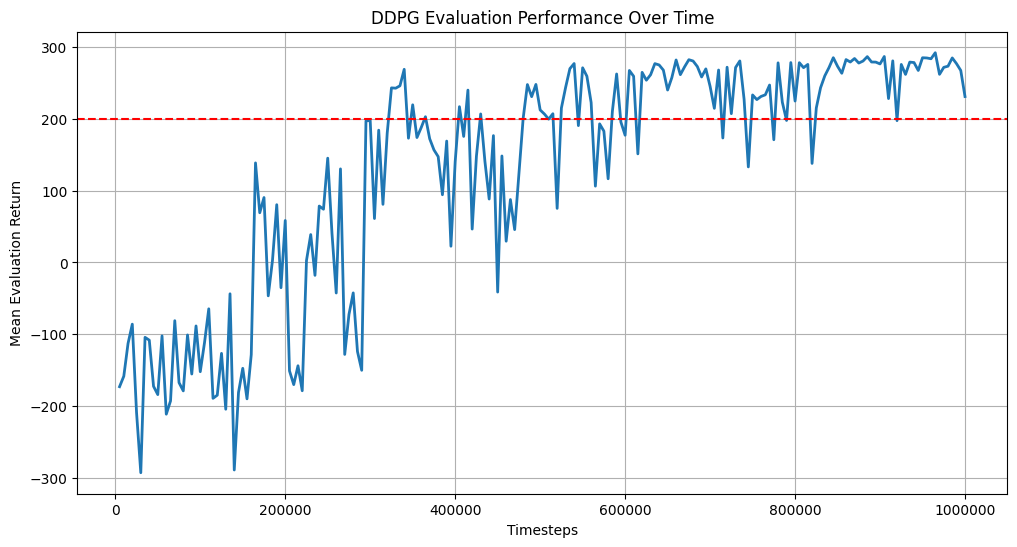

In [11]:
# Convert to DataFrame
results_df = pd.DataFrame(eval_results)

plt.figure(figsize=(12, 6))
plt.plot(results_df["timesteps"], results_df["mean_reward"], linewidth=2)  # thicker line
plt.axhline(y=200, color='red', linestyle='--', linewidth=1.5)  # red dashed horizontal line at 200
plt.xlabel("Timesteps")
plt.ylabel("Mean Evaluation Return")
plt.title("DDPG Evaluation Performance Over Time")
plt.grid(True)
plt.ticklabel_format(style='plain', axis='x')
plt.show()



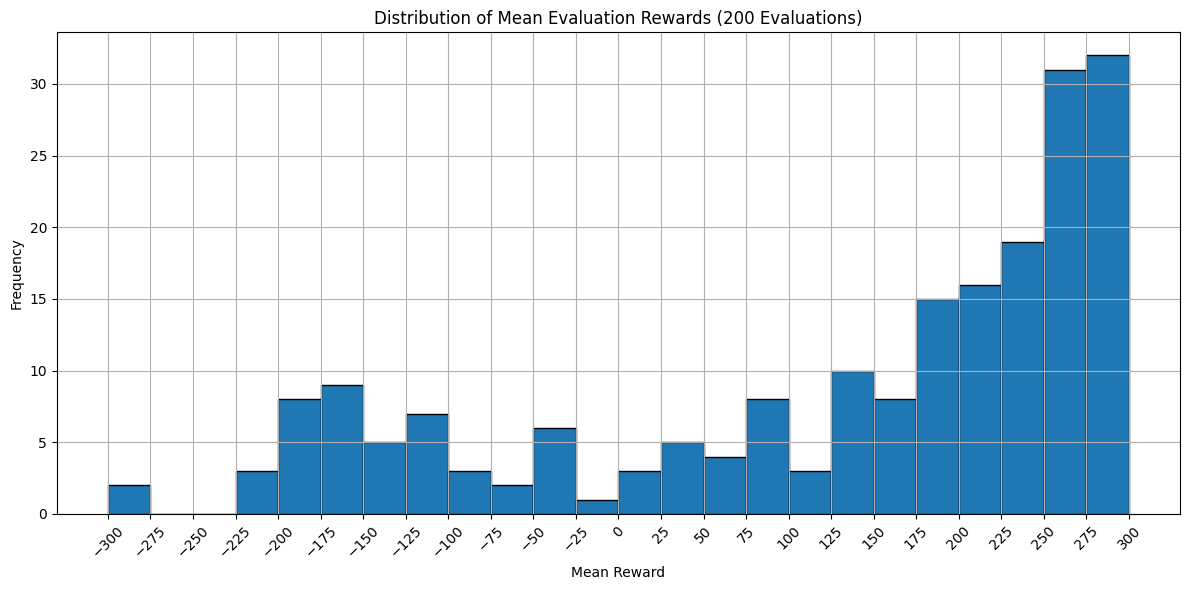

In [12]:
min_reward = results_df["mean_reward"].min()
max_reward = results_df["mean_reward"].max()

# Create bin edges every 25 units from min to max, adding one extra bin to cover max
bins = np.arange(start=np.floor(min_reward / 25) * 25,
                 stop=np.ceil(max_reward / 25) * 25 + 25,
                 step=25)

plt.figure(figsize=(12, 6))
plt.hist(results_df["mean_reward"], bins=bins, edgecolor='k')
plt.xlabel("Mean Reward")
plt.ylabel("Frequency")
plt.title("Distribution of Mean Evaluation Rewards (200 Evaluations)")
plt.grid(True, axis='x')
plt.grid(True, axis='y', which='both')
plt.xticks(bins, rotation=45)
plt.tight_layout()
plt.show()


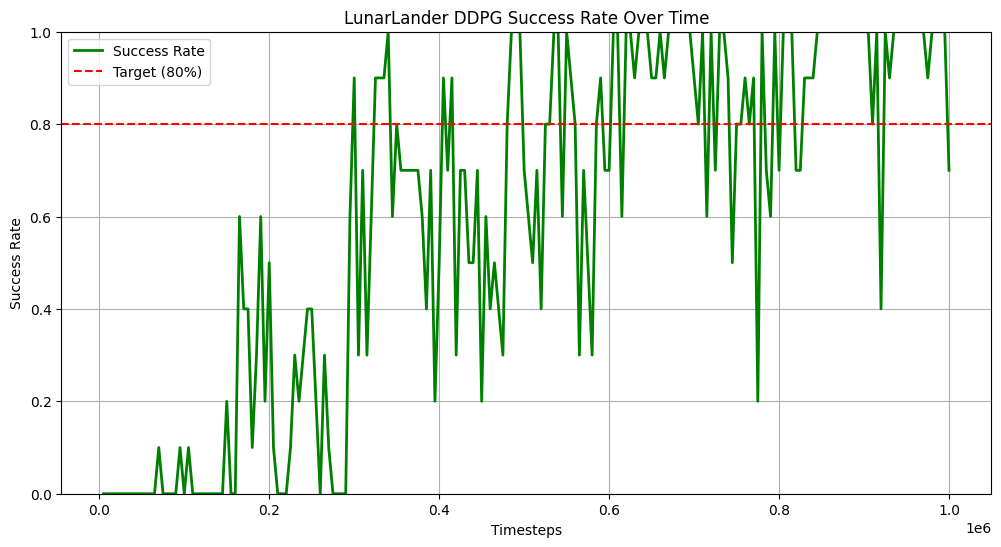

In [13]:
results_df = pd.DataFrame(eval_results)

plt.figure(figsize=(12, 6))
plt.plot(results_df["timesteps"], results_df["success_rate"], label="Success Rate", color="green", linewidth=2)
plt.xlabel("Timesteps")
plt.ylabel("Success Rate")
plt.title("LunarLander DDPG Success Rate Over Time")
plt.grid(True)
plt.ylim(0, 1)
plt.axhline(0.8, color="red", linestyle="--", label="Target (80%)")
plt.legend()
plt.show()


# PPO

In [14]:
from stable_baselines3 import PPO
import gymnasium as gym

In [15]:
# Test/Evaluate PPO agent using your env
env = gym.make("LunarLander-v3", gravity=-10, continuous=True,
               enable_wind=True, wind_power=15.0, turbulence_power=1.5
    )
env.reset(seed=seed_value)

env.close()

In [16]:
# Env Properties
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
action_low = float(env.action_space.low[0])
action_high = float(env.action_space.high[0])

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print('State dimension:', state_dim)
print('Action dimension:', action_dim)
print('Action range:', action_low, 'to', action_high)

Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Box(-1.0, 1.0, (2,), float32)
State dimension: 8
Action dimension: 2
Action range: -1.0 to 1.0


The first experiment trains a PPO agent using the default hyperparameters from Stable Baselines3. Every 5,000 steps, the agent is evaluated in a fresh environment and the results are logged to monitor learning progress throughout training.


In [17]:
# Create PPO model using your existing env
ppo_model = PPO("MlpPolicy", env, verbose=0, tensorboard_log="./ppo_lunar_tensorboard/")

# Train PPO
total_timesteps = 1_000_000
eval_interval = 5000
eval_episodes = 10

episode_rewards = []
eval_results = []
timesteps = 0

def evaluate(model, env, n_episodes=10):
    rewards = []
    for _ in range(n_episodes):
        obs, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            total_reward += reward
        rewards.append(total_reward)
    return np.mean(rewards), rewards

while timesteps < total_timesteps:
    ppo_model.learn(total_timesteps=eval_interval, reset_num_timesteps=False)
    timesteps += eval_interval

    eval_env = gym.make(
        "LunarLander-v3",
        gravity=-10,
        continuous=True,
        enable_wind=True,
        wind_power=15.0,
        turbulence_power=1.5,
    )
    eval_env.reset(seed=seed_value)

    mean_reward, rewards = evaluate(ppo_model, eval_env, n_episodes=eval_episodes)
    episode_rewards.append(mean_reward)

    success_count = sum(r > 200 for r in rewards)
    success_rate = success_count / len(rewards)

    eval_results.append({
        "timesteps": timesteps,
        "mean_reward": mean_reward,
        "success_rate": success_rate
    })
    print(f"Evaluation at step {timesteps}: Mean Reward = {mean_reward:.2f}, Success Rate = {success_rate:.2f}")

    eval_env.close()


ppo_model.save("ppo_lunar_vanilla")
env.close()


Evaluation at step 5000: Mean Reward = -236.34, Success Rate = 0.00
Evaluation at step 10000: Mean Reward = -212.25, Success Rate = 0.00
Evaluation at step 15000: Mean Reward = -199.28, Success Rate = 0.00
Evaluation at step 20000: Mean Reward = -118.12, Success Rate = 0.00
Evaluation at step 25000: Mean Reward = -25.77, Success Rate = 0.00
Evaluation at step 30000: Mean Reward = -30.61, Success Rate = 0.10
Evaluation at step 35000: Mean Reward = -23.20, Success Rate = 0.20
Evaluation at step 40000: Mean Reward = -125.48, Success Rate = 0.00
Evaluation at step 45000: Mean Reward = -85.37, Success Rate = 0.00
Evaluation at step 50000: Mean Reward = 13.05, Success Rate = 0.10
Evaluation at step 55000: Mean Reward = 118.76, Success Rate = 0.50
Evaluation at step 60000: Mean Reward = -24.60, Success Rate = 0.10
Evaluation at step 65000: Mean Reward = 37.40, Success Rate = 0.10
Evaluation at step 70000: Mean Reward = 50.57, Success Rate = 0.20
Evaluation at step 75000: Mean Reward = 32.82, 

In [18]:
results_df = pd.DataFrame(eval_results)


In [19]:
test_env = gym.make(
    "LunarLander-v3",
    gravity=-10,
    continuous=True,
    enable_wind=True, 
    wind_power=15.0,
    turbulence_power=1.5,
    render_mode=None  
)
test_env.reset(seed=seed_value)

(array([ 0.00221748,  1.4181306 ,  0.22392681,  0.3204666 , -0.00196626,
        -0.03906321,  0.        ,  0.        ], dtype=float32),
 {})

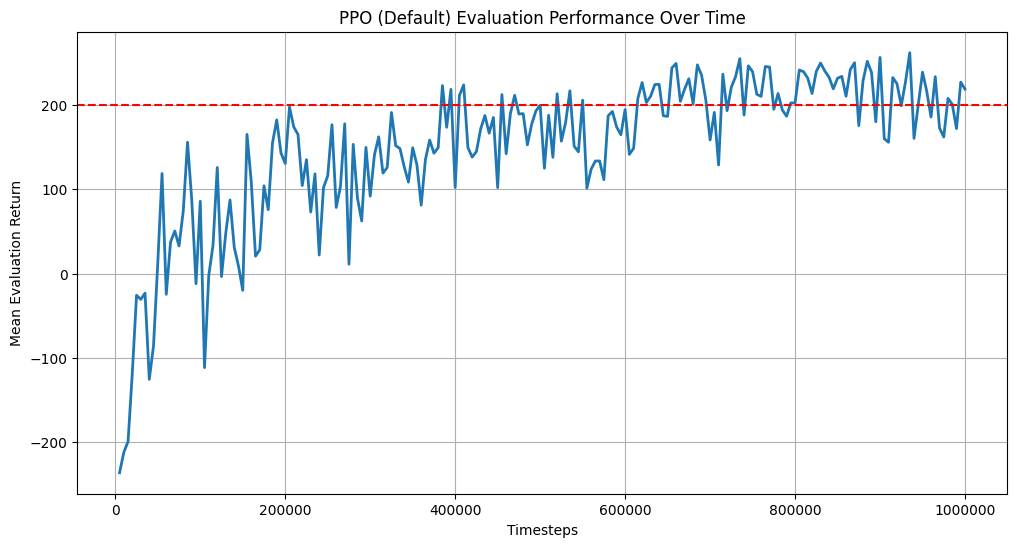

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(results_df["timesteps"], results_df["mean_reward"], linewidth=2)
plt.axhline(y=200, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Timesteps")
plt.ylabel("Mean Evaluation Return")
plt.title("PPO (Default) Evaluation Performance Over Time")
plt.grid(True)
plt.ticklabel_format(style='plain', axis='x')
plt.show()

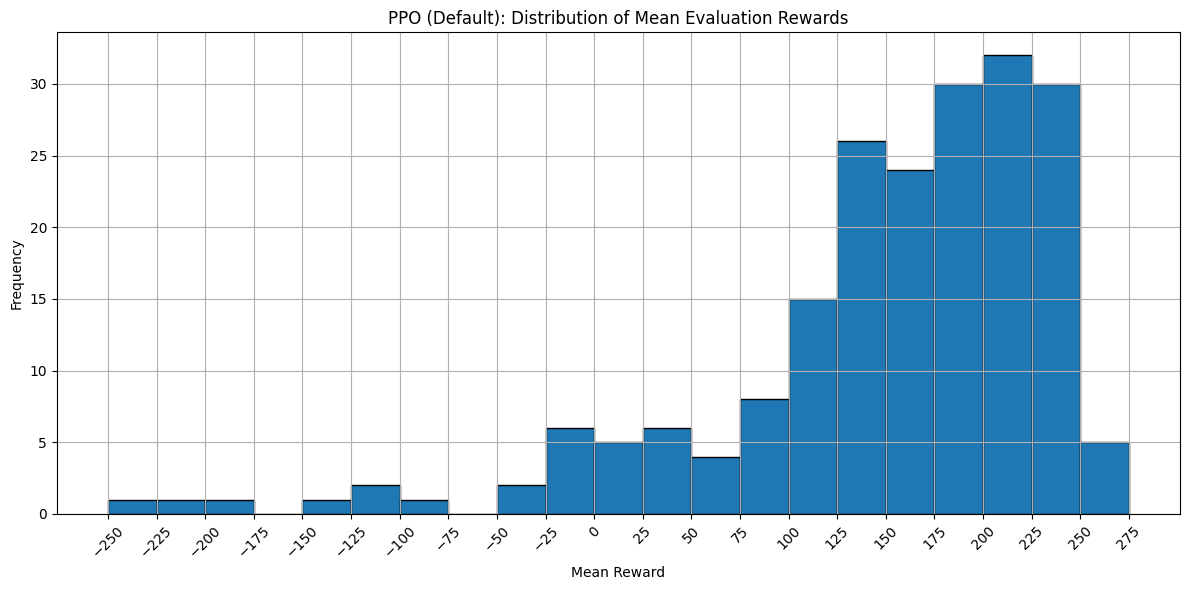

In [21]:
min_reward = results_df["mean_reward"].min()
max_reward = results_df["mean_reward"].max()
bins = np.arange(
    start=np.floor(min_reward / 25) * 25,
    stop=np.ceil(max_reward / 25) * 25 + 25,
    step=25
)
plt.figure(figsize=(12, 6))
plt.hist(results_df["mean_reward"], bins=bins, edgecolor='k')
plt.xlabel("Mean Reward")
plt.ylabel("Frequency")
plt.title("PPO (Default): Distribution of Mean Evaluation Rewards")
plt.grid(True, axis='x')
plt.grid(True, axis='y', which='both')
plt.xticks(bins, rotation=45)
plt.tight_layout()
plt.show()


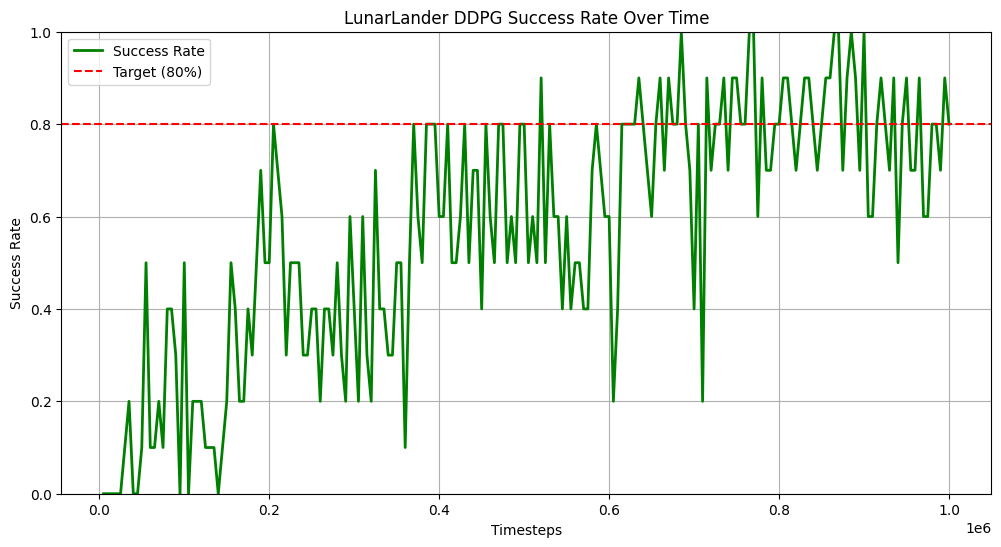

In [22]:
results_df = pd.DataFrame(eval_results)

plt.figure(figsize=(12, 6))
plt.plot(results_df["timesteps"], results_df["success_rate"], label="Success Rate", color="green", linewidth=2)
plt.xlabel("Timesteps")
plt.ylabel("Success Rate")
plt.title("LunarLander DDPG Success Rate Over Time")
plt.grid(True)
plt.ylim(0, 1)
plt.axhline(0.8, color="red", linestyle="--", label="Target (80%)")
plt.legend()
plt.show()


The second experiment explores the impact of custom hyperparameters. In this setup:
- The neural network is deeper (two layers of 256 units for both policy and value)
- Batch size and rollout length are increased
- Learning rate and entropy coefficient are decreased
- More epochs are used per update

The goal is to determine whether these adjustments lead to faster learning or higher average rewards compared to the default setup.


In [23]:
env = gym.make(
    "LunarLander-v3",
    gravity=-10,
    continuous=True,
    enable_wind=True,
    wind_power=15.0,
    turbulence_power=1.5
)
env.reset(seed=seed_value)

(array([ 0.00221748,  1.4181306 ,  0.22392681,  0.3204666 , -0.00196626,
        -0.03906321,  0.        ,  0.        ], dtype=float32),
 {})

In [24]:
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)
print('State dimension:', state_dim)
print('Action dimension:', action_dim)
print('Action range:', action_low, 'to', action_high)

Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Box(-1.0, 1.0, (2,), float32)
State dimension: 8
Action dimension: 2
Action range: -1.0 to 1.0


In [25]:
ppo_model_custom = PPO(
    "MlpPolicy",
    env,
    n_steps=4096,           # Larger rollout for better GAE estimation
    batch_size=256,         # Larger minibatch
    gae_lambda=0.97,        # Slightly lower for less bias, more variance
    gamma=0.99,             # Discount factor
    ent_coef=0.005,         # Less entropy bonus
    learning_rate=1e-4,     # Lower LR for more stable convergence
    n_epochs=20,            # More epochs
    clip_range=0.2,         # Default
    verbose=0,
    tensorboard_log="./ppo_lunar_tensorboard/"
    )

In [26]:
total_timesteps = 1_000_000
eval_interval = 5000
eval_episodes = 10

episode_rewards_custom = []
eval_results_custom = []
timesteps = 0

while timesteps < total_timesteps:
    ppo_model_custom.learn(total_timesteps=eval_interval, reset_num_timesteps=False)
    timesteps += eval_interval

    eval_env = gym.make(
        "LunarLander-v3",
        gravity=-10,
        continuous=True,
        enable_wind=True,
        wind_power=15.0,
        turbulence_power=1.5,
    )
    eval_env.reset(seed=seed_value)

    mean_reward, rewards = evaluate(ppo_model_custom, eval_env, n_episodes=eval_episodes)
    episode_rewards_custom.append(mean_reward)

    success_count = sum(r > 200 for r in rewards)
    success_rate = success_count / len(rewards)

    eval_results_custom.append({
        "timesteps": timesteps,
        "mean_reward": mean_reward,
        "success_rate": success_rate
    })

    print(f"Custom PPO - Evaluation at step {timesteps}: Mean Reward = {mean_reward:.2f}, Success Rate = {success_rate:.2f}")

    eval_env.close()

ppo_model_custom.save("ppo_lunar_custom")
env.close()


Custom PPO - Evaluation at step 5000: Mean Reward = -171.61, Success Rate = 0.00
Custom PPO - Evaluation at step 10000: Mean Reward = -236.34, Success Rate = 0.00
Custom PPO - Evaluation at step 15000: Mean Reward = -213.27, Success Rate = 0.00
Custom PPO - Evaluation at step 20000: Mean Reward = -183.13, Success Rate = 0.00
Custom PPO - Evaluation at step 25000: Mean Reward = -138.74, Success Rate = 0.00
Custom PPO - Evaluation at step 30000: Mean Reward = -109.20, Success Rate = 0.00
Custom PPO - Evaluation at step 35000: Mean Reward = -148.60, Success Rate = 0.00
Custom PPO - Evaluation at step 40000: Mean Reward = -170.56, Success Rate = 0.00
Custom PPO - Evaluation at step 45000: Mean Reward = -116.37, Success Rate = 0.10
Custom PPO - Evaluation at step 50000: Mean Reward = -19.10, Success Rate = 0.10
Custom PPO - Evaluation at step 55000: Mean Reward = -101.19, Success Rate = 0.00
Custom PPO - Evaluation at step 60000: Mean Reward = -8.66, Success Rate = 0.20
Custom PPO - Evaluat

In [27]:
results_df_custom = pd.DataFrame(eval_results_custom)

In [28]:
test_env = gym.make(
    "LunarLander-v3",
    gravity=-10,
    continuous=True,
    enable_wind=True,
    wind_power=15.0,
    turbulence_power=1.5,
    render_mode="human"
)
test_env.reset(seed=seed_value)

# Load the model (already saved previously, or use the variable from training)
ppo_model = PPO.load("ppo_lunar_vanilla")

# Run and render a few episodes
for ep in range(10):
    obs, _ = test_env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = ppo_model.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, _ = test_env.step(action)
        done = terminated or truncated
        total_reward += reward
    print(f"Test Episode {ep+1}: Reward = {total_reward:.2f}")
test_env.close()

Test Episode 1: Reward = 267.78
Test Episode 2: Reward = 265.87
Test Episode 3: Reward = 17.98
Test Episode 4: Reward = 199.86
Test Episode 5: Reward = 264.02
Test Episode 6: Reward = 217.09
Test Episode 7: Reward = 255.77
Test Episode 8: Reward = 224.34
Test Episode 9: Reward = 258.10
Test Episode 10: Reward = 219.14


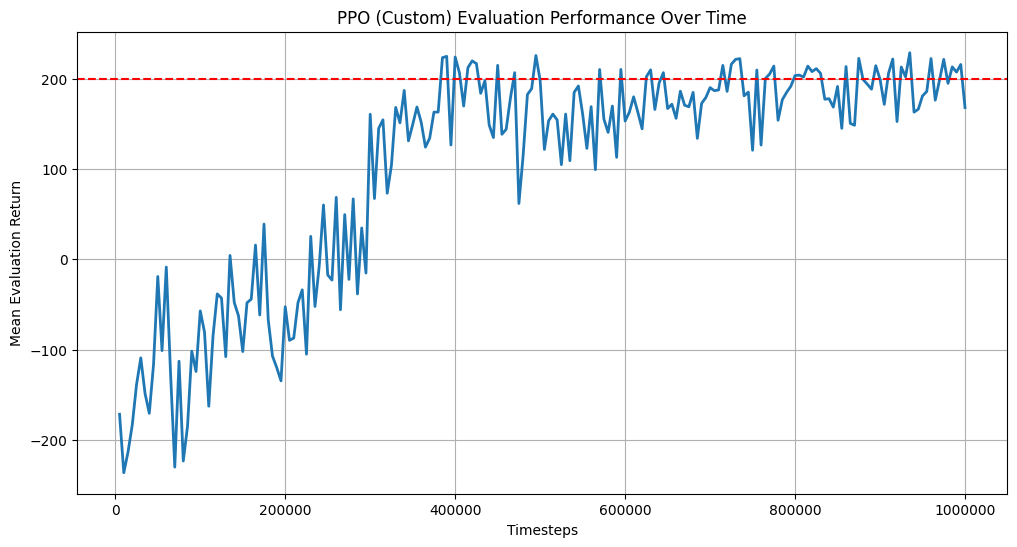

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(results_df_custom["timesteps"], results_df_custom["mean_reward"], linewidth=2)
plt.axhline(y=200, color='red', linestyle='--', linewidth=1.5)
plt.xlabel("Timesteps")
plt.ylabel("Mean Evaluation Return")
plt.title("PPO (Custom) Evaluation Performance Over Time")
plt.grid(True)
plt.ticklabel_format(style='plain', axis='x')
plt.show()


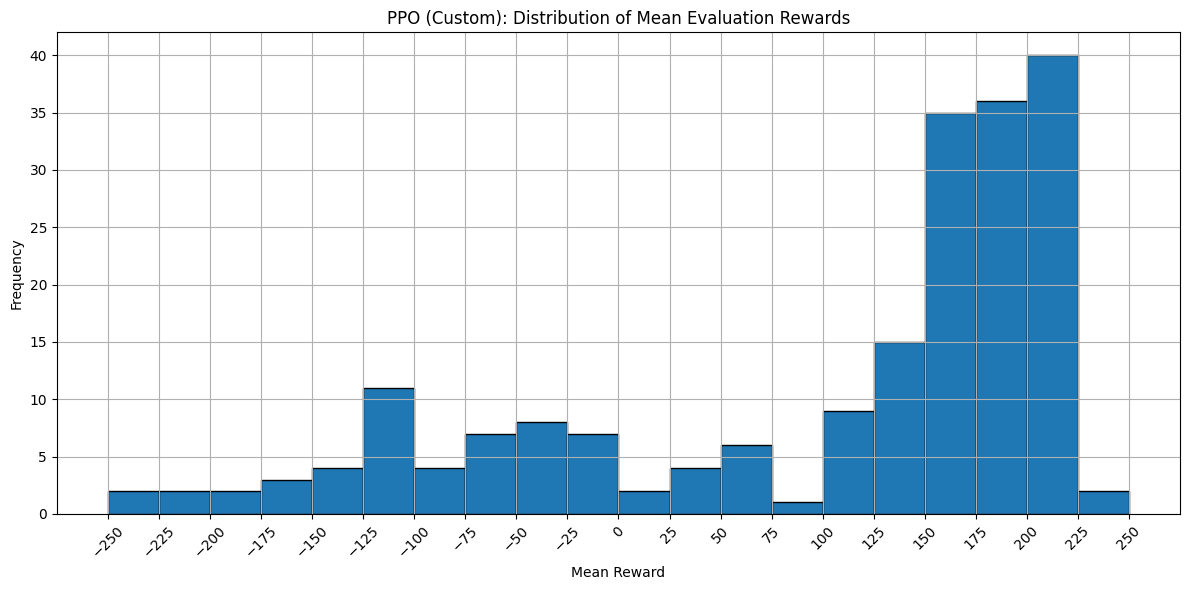

In [30]:
min_reward_custom = results_df_custom["mean_reward"].min()
max_reward_custom = results_df_custom["mean_reward"].max()
bins_custom = np.arange(
    start=np.floor(min_reward_custom / 25) * 25,
    stop=np.ceil(max_reward_custom / 25) * 25 + 25,
    step=25
)
plt.figure(figsize=(12, 6))
plt.hist(results_df_custom["mean_reward"], bins=bins_custom, edgecolor='k')
plt.xlabel("Mean Reward")
plt.ylabel("Frequency")
plt.title("PPO (Custom): Distribution of Mean Evaluation Rewards")
plt.grid(True, axis='x')
plt.grid(True, axis='y', which='both')
plt.xticks(bins_custom, rotation=45)
plt.tight_layout()
plt.show()

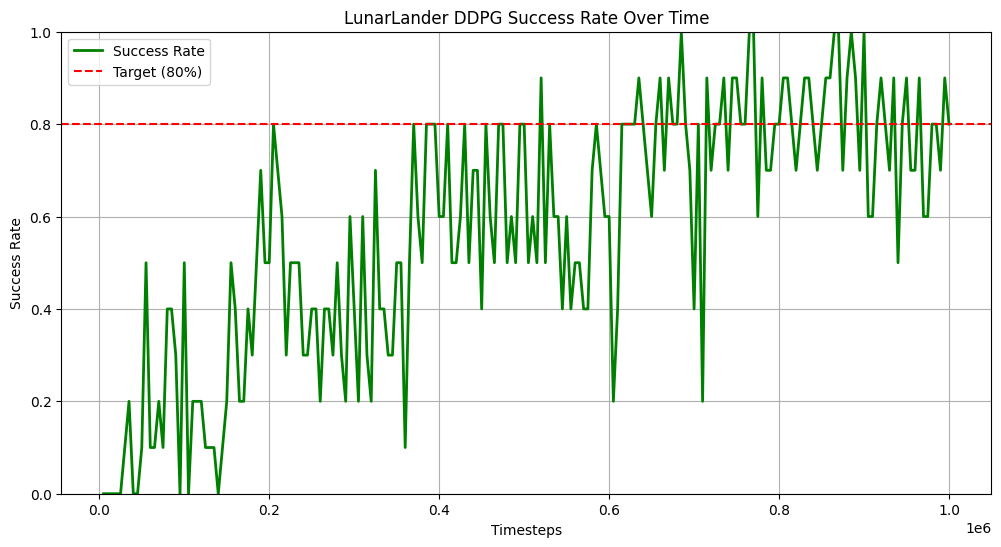

In [31]:
results_df = pd.DataFrame(eval_results)

plt.figure(figsize=(12, 6))
plt.plot(results_df["timesteps"], results_df["success_rate"], label="Success Rate", color="green", linewidth=2)
plt.xlabel("Timesteps")
plt.ylabel("Success Rate")
plt.title("LunarLander DDPG Success Rate Over Time")
plt.grid(True)
plt.ylim(0, 1)
plt.axhline(0.8, color="red", linestyle="--", label="Target (80%)")
plt.legend()
plt.show()
